## Import Packages

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_ubyte

# import pytorch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    get_world_to_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftSilhouetteShader,
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    Textures
)
from pytorch3d.transforms import (
    euler_angles_to_matrix,
    axis_angle_to_matrix
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

## Setup

In [2]:
# device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print('Using device: {}'.format(device))
# Set paths
# DATA_DIR = "/home/shubham/workspace/ford/SiriusRenderNet/data/cr3"
# obj_filename = os.path.join(DATA_DIR, "textured_output.obj")
# DATA_DIR = "/floppy/datasets/PoseGen/Car 3D Models/Tesla"
# obj_filename = os.path.join(DATA_DIR, "Tesla Model.obj")
DATA_DIR = "/floppy/datasets/PoseGen/Car 3D Models/Audi"
obj_filename = os.path.join(DATA_DIR, "audi_scaled.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
# verts, faces_idx, _ = load_obj(obj_filename)
# faces = faces_idx.verts_idx

# # Initialize each vertex to be white in color.
# verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
# textures = Textures(verts_rgb=verts_rgb.to(device))

# # Create a Meshes object for the teapot. Here we have only one mesh in the batch.
# mesh = Meshes(
# verts=[verts.to(device)],
# faces=[faces.to(device)],
# textures=textures
# )

Using device: cuda:0


## Define transformation functions

In [3]:
import numpy as np
def rotx(t):
    """Rotation about the x-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1,  0,  0],
                     [0,  c, -s],
                     [0,  s,  c]])


def roty(t):
    """Rotation about the y-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c,  0,  s],
                     [0,  1,  0],
                     [-s, 0,  c]])


def rotz(t):
    """Rotation about the z-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s,  0],
                     [s,  c,  0],
                     [0,  0,  1]])

def rot_mat(rx, ry, rz):
    return np.dot(rotx(rx), np.dot(roty(ry), rotz(rz)))

def transform_from_rot_trans(R, t):
    """Transforation matrix from rotation matrix and translation vector."""
    R = R.reshape(3, 3)
    t = t.reshape(3, 1)
    return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))

def transformation_mat(rx, ry, rz, tx, ty, tz):
    R = rot_mat(rx, ry, rz)
    t = np.array([tx, ty, tz], dtype=np.float32)
    return transform_from_rot_trans(R, t)

## Create a Renderer

A renderer in PyTorch3D is composed of a rasterizer and a shader which each have a number of subcomponents such as a camera (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

Here, we will first create a renderer which uses a perspective camera, a point light and applies phong shading. 

In [4]:
# Initialize a camera.
R, T = look_at_view_transform(dist=3.0, elev=0.0, azim=0.0) 
T = torch.Tensor([[0.0, 0.0, 3.0]])
# define camera
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

img_size = (720, 1280)
# print transformation matrix
print('Rotation:\n{}'.format(R))
print('Translation:\n{}'.format(T))

# Blending Parameters
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. 
# Let's set faces_per_pixel=1 and blur_radius=0.0. 
# We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings=RasterizationSettings(
            image_size=img_size, 
            blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=100, 
        )

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Place a point light in front of the object.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
#     shader=SoftPhongShader(
#         device=device, 
#         cameras=cameras,
#         lights=lights
#     )
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

Rotation:
tensor([[[-1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0., -1.]]])
Translation:
tensor([[0., 0., 3.]])


## Render the mesh

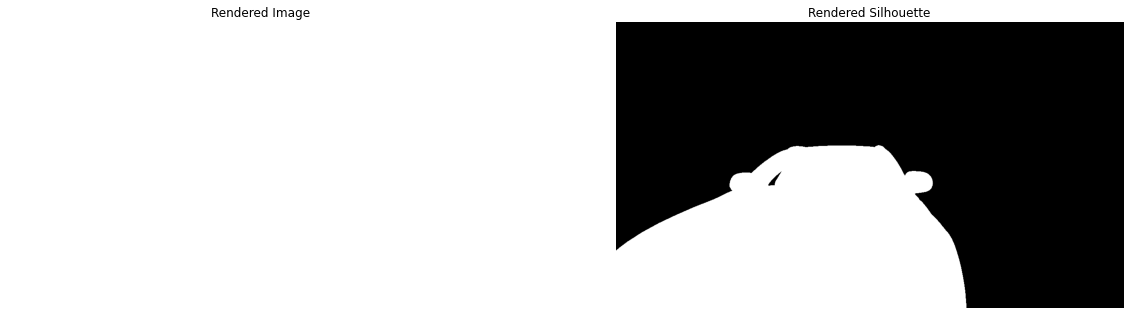

In [5]:
images = renderer(meshes_world=mesh, R=R.to(device), T=T.to(device))
silhouette = silhouette_renderer(meshes_world=mesh, R=R.to(device), T=T.to(device))
mask = silhouette > torch.Tensor([0.0]).to(device)
silhouette[mask] = silhouette[mask] / silhouette[mask] # set everything > 0. to 1.0
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.title('Rendered Image')
plt.grid("off");
plt.axis("off");
plt.subplot(1,2,2)
plt.imshow(silhouette[0, ..., 3].cpu().numpy(), cmap='gray') # plot only the alpha channel of RGBA
plt.title('Rendered Silhouette')
plt.grid("off");
plt.axis("off");

## Render the images

In [14]:
import itertools
from PIL import Image

dst_dir = '/floppy/datasets/PoseGen/rendered_silhouette'
if not os.path.exists(dst_dir):
    os.system('mkdir -p {}'.format(dst_dir))
    
x_range = np.arange(-0.5, 0.5, 0.3)
y_range = np.arange(-0.5, 0.5, 0.3)
z_range = np.arange(4.0, 6.0, 0.5)
yaw_range = np.array(list(np.arange(0.0, 120.0, 5.0))+list(np.arange(240.0, 360.0, 5.0)))

var_range = list(itertools.product(x_range, y_range, z_range, yaw_range))
for i, [x, y, z, yaw] in enumerate(var_range):
    print('\rRendering image: [{}/{}]'.format(i, len(var_range)), end='')
    # Initialize a camera.
    R, T = look_at_view_transform(dist=3.0, elev=0.0, azim=yaw) 
    T = torch.Tensor([[x, y, z]])
    # define camera
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    img_size = (256, 256)

    # Blending Parameters
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

    # Define the settings for rasterization and shading. 
    # Let's set faces_per_pixel=1 and blur_radius=0.0. 
    # We also set bin_size and max_faces_per_bin to None which ensure that 
    # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
    # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
    # the difference between naive and coarse-to-fine rasterization. 
    raster_settings=RasterizationSettings(
                image_size=img_size, 
                blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
                faces_per_pixel=100, 
            )

    # Create a silhouette mesh renderer by composing a rasterizer and a shader. 
    silhouette_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftSilhouetteShader(blend_params=blend_params)
    )

    # Place a point light in front of the object.
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
    # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
    # apply the Phong lighting model
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
    #     shader=SoftPhongShader(
    #         device=device, 
    #         cameras=cameras,
    #         lights=lights
    #     )
        shader=SoftSilhouetteShader(blend_params=blend_params)
    )
    
    silhouette = silhouette_renderer(meshes_world=mesh, R=R.to(device), T=T.to(device))
    mask = silhouette > torch.Tensor([0.0]).to(device)
    silhouette[mask] = silhouette[mask] / silhouette[mask] # set everything > 0. to 1.0
    
    # filename
    fname = os.path.join(dst_dir, str(i).zfill(6)+'.png')
    sil_rgb = Image.fromarray(silhouette[0, ..., 3].cpu().numpy()*255.0).convert("RGB")
    sil_rgb.save(fname)

Rendering image: [3071/3072]